In [2]:
import pandas as pd
import numpy as np
import pickle

In [3]:
#df = pd.read_json(r"Data/modcloth_final_data.json", lines=True)
#df.to_csv(r"Data/ClothingRatingsMod.csv")

# Import Dataset

In [4]:
mod = pd.read_csv(r"Data/ClothingRatingsMod.csv")

/var/folders/kz/950pxqcd0zn5rw95_9btv5p00000gn/T/ipykernel_79216/1836474290.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  mod = pd.read_csv(r"Data/ClothingRatingsMod.csv")


# Dress Data

In [5]:
mod = mod[mod['category'] == 'dresses']

# Take columns as features, size as classifcation

In [6]:
mod = mod[['waist', 'hips', 'bust', 'size']]
mod = mod.reset_index().iloc[:, 1:]
#waist, hips, bust, size

# Use Binning to discretize data into actual sizes

In [7]:
min_value = mod['size'].min()
max_value = mod['size'].max()

In [8]:
bins = np.linspace(min_value,max_value,5)
labels = ['S', 'M', 'L', 'XL']

In [9]:
mod['bins'] = pd.cut(mod['size'], bins=bins, labels=labels, include_lowest=True)
mod = mod.drop('size', axis=1)


In [10]:
mod['bins'].value_counts()

S     8877
M     6250
L     2675
XL     848
Name: bins, dtype: int64

# New Dataset

In [11]:
import pandas as pd
import numpy as np

In [12]:
mod = pd.read_csv(r"Data/ClothingRatingsWHB.csv")

In [13]:
size_key = {'0': 'L', '1': 'M', '2': 'S', '3': 'XL'}

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
mod['bins'] = le.fit_transform(mod['bins'])

In [14]:
X, y = mod.iloc[:, :-1], mod.iloc[:, -1]

In [15]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
imputer.fit(X)
X = imputer.transform(X)

In [16]:
from sklearn.cluster import KMeans

mod = pd.DataFrame({'waist': X[:, 0], 'hips': X[:, 1], 'bust': X[:, 2]})

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


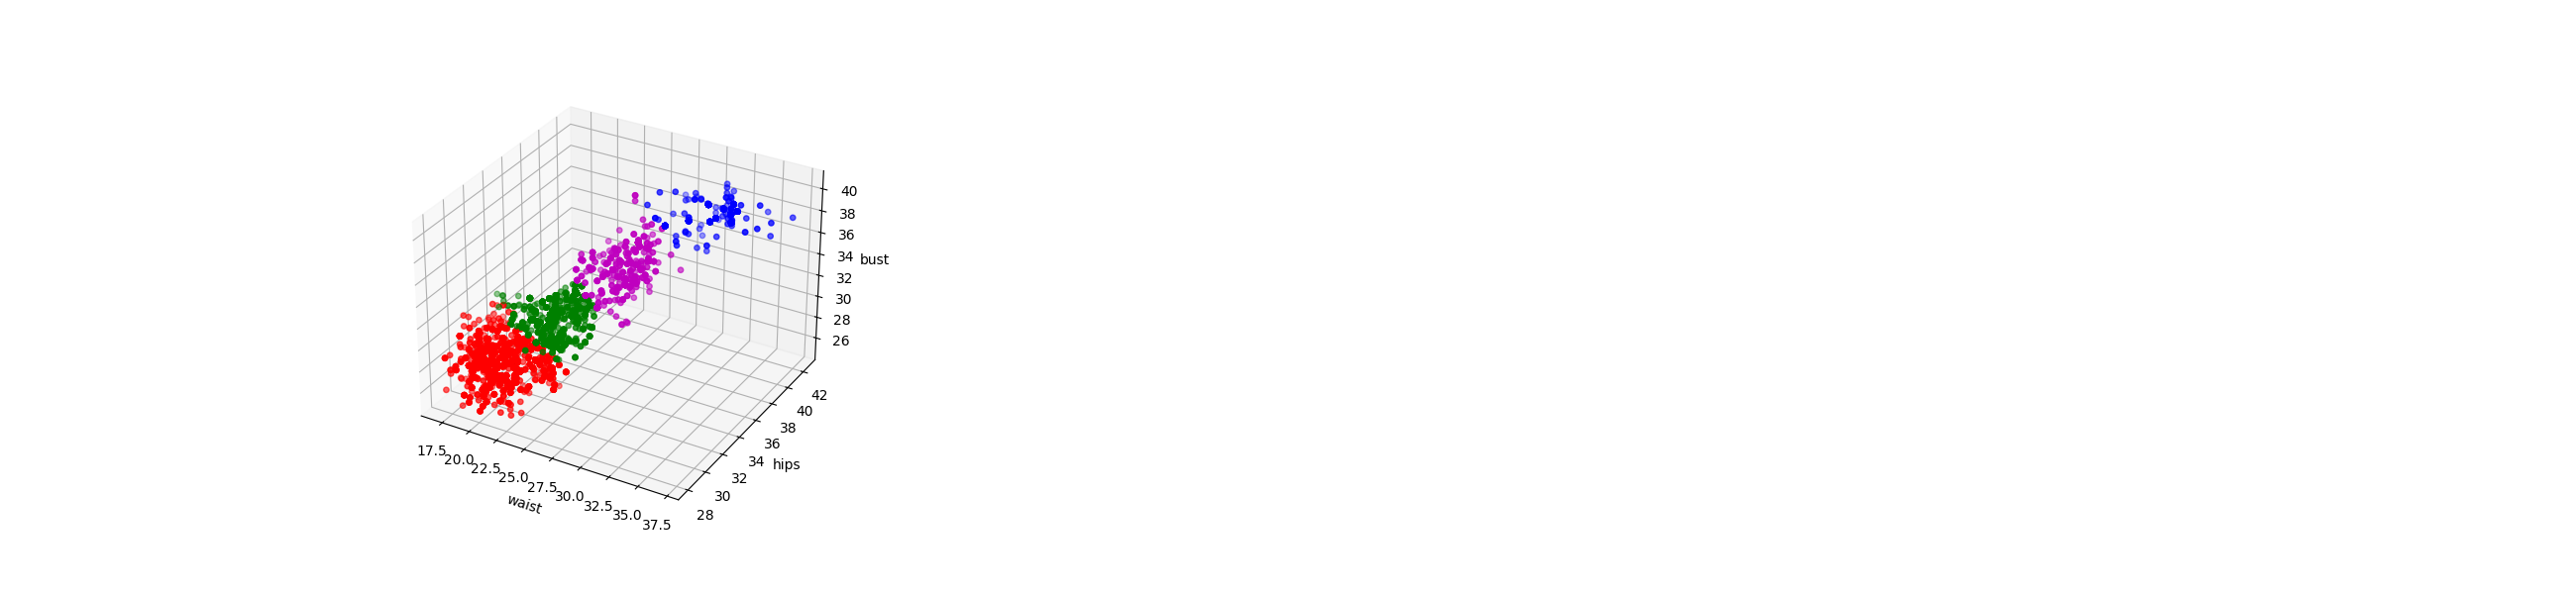

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
colors = ['r', 'b', 'g', 'm']

kmeans = KMeans(n_clusters=4, random_state=0)
mod['cluster'] = kmeans.fit_predict(mod[['waist', 'hips', 'bust']])
mod['c'] = mod.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(mod.waist, mod.hips, mod.bust, c=mod.c, s=15)
ax.set_xlabel('waist')
ax.set_ylabel('hips')
ax.set_zlabel('bust')
plt.show()

In [18]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

'''
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=26)
X_resampled, y_resampled = ros.fit_resample(X, y)
'''

'\nfrom imblearn.over_sampling import RandomOverSampler\nros = RandomOverSampler(random_state=26)\nX_resampled, y_resampled = ros.fit_resample(X, y)\n'

In [19]:
y.value_counts(), y_resampled.value_counts()

(2    8877
 1    6250
 0    2675
 3     848
 Name: bins, dtype: int64,
 2    8877
 1    8877
 0    8877
 3    8877
 Name: bins, dtype: int64)

In [20]:
mod_resampled = pd.DataFrame({'waist': X_resampled[:, 0], 'hips': X_resampled[:, 1], 'bust': X_resampled[:, 2]})

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


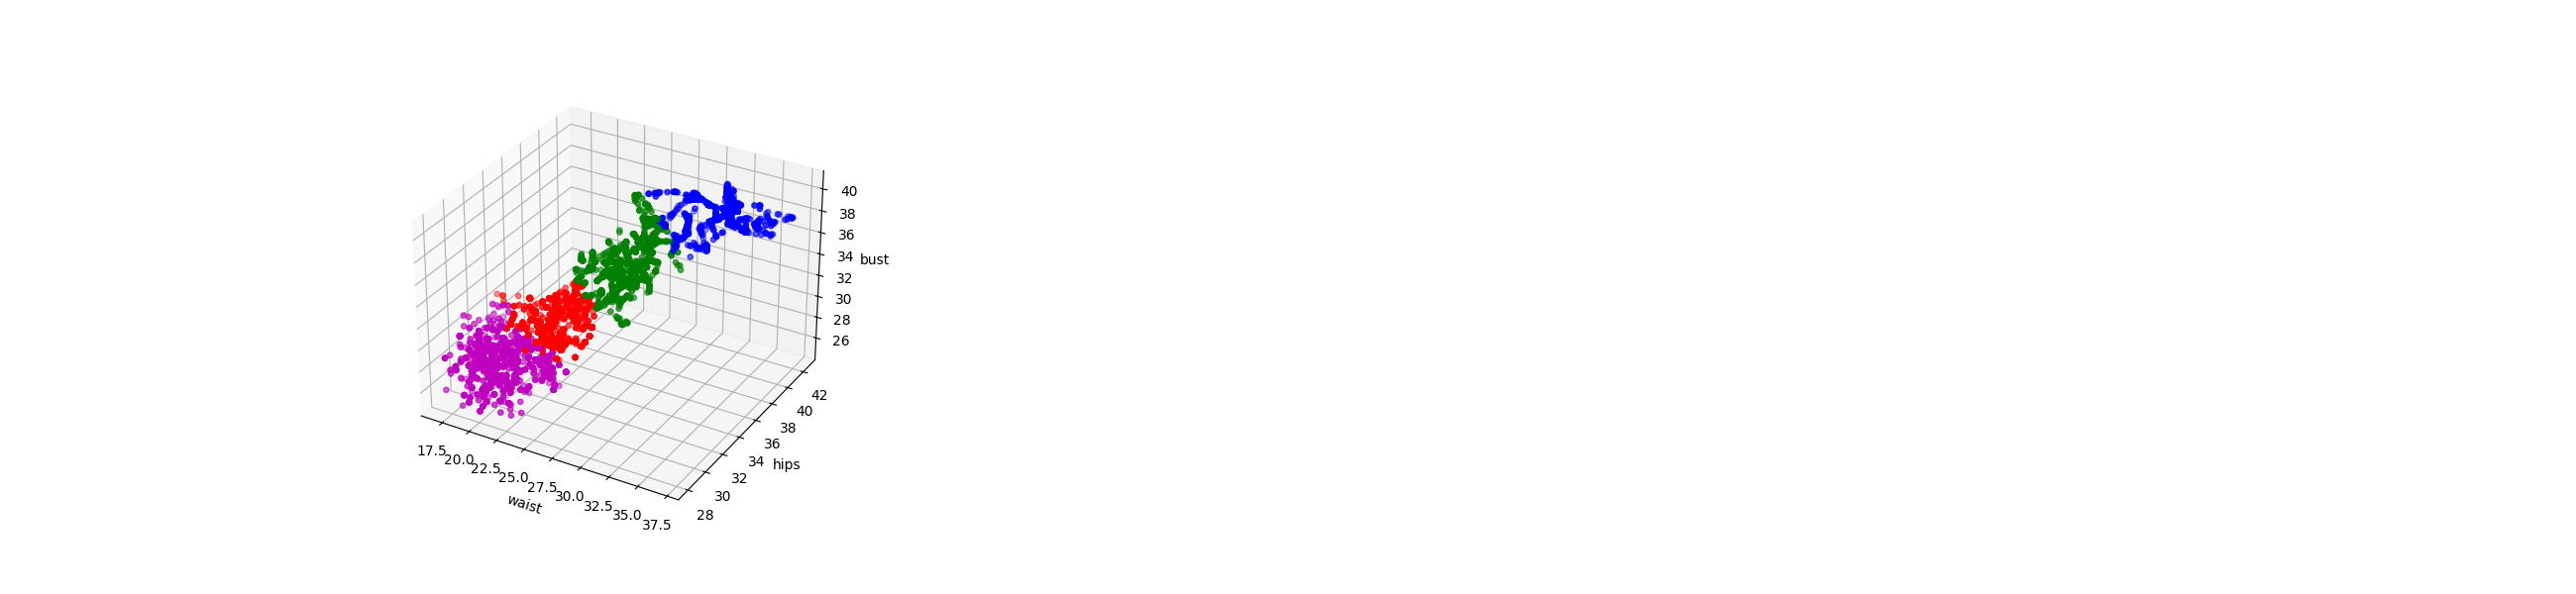

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
colors = ['r', 'b', 'g', 'm']

kmeans = KMeans(n_clusters=4, random_state=0)
mod_resampled['cluster'] = kmeans.fit_predict(mod_resampled[['waist', 'hips', 'bust']])
mod_resampled['c'] = mod_resampled.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(mod_resampled.waist, mod_resampled.hips, mod_resampled.bust, c=mod_resampled.c, s=15)
ax.set_xlabel('waist')
ax.set_ylabel('hips')
ax.set_zlabel('bust')
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [23]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [24]:
clf.score(X_test, y_test)

0.6388341312306393

In [25]:
size_key[str(clf.predict([[30, 32.5, 30.5]])[0])]

'M'

In [26]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [27]:
neigh.score(X_test, y_test)

0.6424950718107575

In [28]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [29]:
tree.score(X_test, y_test)

0.654745142213461

In [30]:
#waist, hips, bust
size_key[str(neigh.predict([[23.5, 33, 31]])[0])]

'M'

In [32]:
pickle.dump(tree, open('TreeModel.pkl', 'wb'))